# TFM: Selección del modelo de predicción
## Diego Sanz Alonso

### 1) Importar librerías y creación de funciones auxiliares

In [1]:
#Only show warnings once
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import neighbors, tree
from sklearn import linear_model
from sklearn import svm
import pickle
from math import ceil
import os

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

### 2) Leer datos y crear conjunto de entrenamiento y test

In [7]:
input_data = "datasets/dataframes/"
df_file = "classes_processed_v1.csv"

print("Reading data")

# Classes dataframe
classes_df = pd.read_csv(input_data + df_file)

label = "Has bugs"

# Atts and label(binary -> False: no bugs, True: bugs)
classes_df_atts = classes_df.drop([label], axis = 1)
classes_df_label = classes_df[label]

print("Clases sin bugs (negativos): ",len(classes_df_label[~classes_df_label]))
print("Clases con bugs (positivos): ", len(classes_df_label[classes_df_label]))
print("Proporcion de clases con bugs: ", round(len(classes_df_label[classes_df_label])/len(classes_df_label)*100,2),'%')

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(classes_df_atts, classes_df_label, test_size=0.33, stratify=classes_df_label)


# Train and test df
train_df = X_train.copy()
train_df[label] = y_train.copy()

test_df = X_test.copy()
test_df[label] = y_test.copy()

Reading data
Clases sin bugs (negativos):  174396
Clases con bugs (positivos):  8275
Proporcion de clases con bugs:  4.53 %


### 3) Árbol de decisión

In [10]:
def tryModel(model, X_train, y_train, X_test, y_test):
    clf = model.fit(X_train, y_train)
    prediction = clf.predict(X_test) 
    precision = precision_score(y_test,prediction)
    recall = recall_score(y_test,prediction)
    f1 = f1_score(y_test,prediction)
    roc = roc_auc_score(y_test, prediction)
    return precision, recall, f1, roc

In [4]:
# Dado un modelo, realiza la validacion cruzada
model = tree.DecisionTreeClassifier()
tryModel(model, X_train, y_train, X_test, y_test)

NameError: name 'X_train' is not defined

Vamos a intentar optimizar 2 de los muchos parámetros que puede tener el árbol de decisión:

* **Profundidad máxima** que pueda alcanzar el árbol. Por defecto el árbol se expande entero (**None**), pero debemos evitar ramificar demasiadas hojas y controlar el sobreajuste.
* **Número mínimo de ejemplos que debe tener en una hoja** para poder particionarse. En caso de que se llegue a un nodo que no sea hoja pero número de instancias es menor al requerido, entonces el algoritmo no ramifica y lo convierte en hoja.


In [5]:
def bruteTree(X_train, y_train, X_test, y_test):
    """Obtener la mejor configuración para un clasificador de
    árbol de predicción mediante búsqueda por fuerza bruta."""
    # Puntuación inicial
    mejorScore = 0
    mejorconf = None

    # Iterar configuraciones
    for i, j in [(i, j) for i in [None] + list(range(1,20,2)) for j in list(range(2,20,3))]:
        model = tree.DecisionTreeClassifier(max_depth = i, min_samples_split = j)
        # Validacion cruzada para testear parametros
        scores = cross_val_score(model, X_train, y_train, cv = 5, scoring="f1")
        score = scores.mean()
        # Actualizar puntuación
        if (score > mejorScore):
            mejorScore = score
            mejorconf = (i,j)
    # Devolve mejor configuración
    return mejorconf

In [8]:
#bruteTree(X_train, y_train, X_test, y_test)
# Resultados: (None, 2)

Vemos que ha tomado los valores por defecto de este modelo. Ahora, vamos a intentar seleccionar algunas variables en lugar de utilizar todas.

In [6]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

def bestNAtts(X_train, y_train, X_test, y_test):
    n_atts = 0
    best_K = None
    best_score = 0
    for i in range(len(X_train.columns)):
        n_atts = i + 1
        X_train_transformed = SelectKBest(chi2, k=n_atts).fit_transform(X_train,y_train)
        model = tree.DecisionTreeClassifier()
        scores = cross_val_score(model, X_train_transformed, y_train, cv = 10, scoring="f1")
        score = scores.mean()
        if (score > best_score):
            print("Mejora con ", n_atts, "atributos, consiguiendo un F1-Score en la validación cruzada de ", score)
            best_score = scores.mean()
            best_K = n_atts
    return best_K, best_score

In [8]:
# bestNAtts(X_train, y_train, X_test, y_test)
# Resultado: 69

In [14]:
# Dado un modelo, realiza la validacion cruzada
transformer = SelectKBest(chi2, k=69)
X_train_transformed = transformer.fit_transform(X_train,y_train)
X_test_transformed = transformer.transform(X_test)
model = tree.DecisionTreeClassifier()
tryModel(model, X_train_transformed, y_train, X_test_transformed, y_test)

(0.3108320251177394, 0.2900036616623947, 0.3000568289448759, 0.629745797052462)

#### 3.1) Undersampling

Vamos a eliminar parte de los casos positivos de entrenamiento para intentar tener un mejor modelo.

In [7]:
def undersampling(df, frac_negatives = 0.5):
    # Positive cases
    train_df_positive = df[df[label]]
    # Negative cases -> Delete some cases
    train_df_negative = df[~df[label]]
    train_df_negative = train_df_negative.sample(frac = frac_negatives)
    # Join negative and positives cases
    train_df_undersampling = train_df_positive.append(train_df_negative).sample(frac=1)
    # Separate in attributes and label
    X_undersampling = train_df_undersampling.drop(label, 1)
    y_undersampling = train_df_undersampling[label]

    return X_undersampling, y_undersampling

In [35]:
def bestNegFrac(df):
    # Dividir conjunto de entrenamiento en otro conjunto de entrenamiento y test
    _X_train, _X_test, _y_train, _y_test = train_test_split(classes_df_atts, classes_df_label, test_size=0.33, stratify=classes_df_label)
    _train_df = _X_train.copy()
    _train_df[label] = _y_train.copy()
    _test_df = _X_test.copy()
    _test_df[label] = _y_test.copy()
    
    # Para cada porcentaje de casos negativos entrenar y ver score
    frac_negatives = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.025, 0]
    best_frac = None
    best_score = 0
    for frac in frac_negatives:
        _X_under, _y_under = undersampling(_train_df, frac_negatives = frac)
        model = tree.DecisionTreeClassifier()
        p, r, s, a = tryModel(model, _X_under, _y_under, _X_test, _y_test)
        score = s
        if (score > best_score):
            print("Eligiendo", frac*100, '% de los datos negativos. Precisión',round(p,4),';Recall',round(r,4),';F1',round(s,4),';ROC ',round(a,4))
            best_frac = frac
            best_score = score
    return best_frac
bestNegFrac(train_df)

Eligiendo 90.0 % de los datos negativos. Precisión 0.2905 ;Recall 0.2929 ;F1 0.2917 ;ROC  0.6295
Eligiendo 80.0 % de los datos negativos. Precisión 0.279 ;Recall 0.3197 ;F1 0.298 ;ROC  0.6402
Eligiendo 70.0 % de los datos negativos. Precisión 0.2821 ;Recall 0.3398 ;F1 0.3083 ;ROC  0.6494


0.7

In [36]:
X_undersampling, y_undersampling = undersampling(train_df, frac_negatives = 0.7)
print("Clases sin bugs (negativos): ",len(y_undersampling[~y_undersampling]))
print("Clases con bugs (positivos): ", len(y_undersampling[y_undersampling]))
print("Proporcion de clases con bugs: ", round(len(y_undersampling[y_undersampling])/len(y_undersampling)*100,2),'%')

Clases sin bugs (negativos):  81792
Clases con bugs (positivos):  5544
Proporcion de clases con bugs:  6.35 %


In [37]:
# Dado un modelo, realiza la validacion cruzada
model = tree.DecisionTreeClassifier()
tryModel(model, X_undersampling, y_undersampling, X_test, y_test)

(0.2605612998522895,
 0.32295862321493957,
 0.2884238064094179,
 0.6397333819103316)

#### 3.2) Replicar casos positivos

Ahora vamos a intentar lo inverso: aumentar el número de casos positivos.

In [8]:
def oversampling(df, frac_positives = 2):
    # Positive cases -> Add some cases
    train_df_positive = df[df[label]]
    train_df_positive = train_df_positive.append(train_df_positive.sample(frac=frac_positives-1))
    # Negative cases 
    train_df_negative = df[~df[label]]
    # Join negative and positives cases
    train_df_undersampling = train_df_positive.append(train_df_negative).sample(frac=1)
    # Separate in attributes and label
    X_undersampling = train_df_undersampling.drop(label, 1)
    y_undersampling = train_df_undersampling[label]

    return X_undersampling, y_undersampling

In [41]:
def bestPosFrac(df):
    # Dividir conjunto de entrenamiento en otro conjunto de entrenamiento y test
    _X_train, _X_test, _y_train, _y_test = train_test_split(classes_df_atts, classes_df_label, test_size=0.33, stratify=classes_df_label)
    _train_df = _X_train.copy()
    _train_df[label] = _y_train.copy()
    _test_df = _X_test.copy()
    _test_df[label] = _y_test.copy()
    
    # Para cada porcentaje de casos positivos entrenar y ver score
    frac_positives = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
    best_frac = None
    best_score = 0
    for frac in frac_positives:
        _X_under, _y_under = oversampling(_train_df, frac_positives = frac)
        model = tree.DecisionTreeClassifier()
        p, r, s, a = tryModel(model, _X_under, _y_under, _X_test, _y_test)
        score = s
        if (score > best_score):
            print("Eligiendo", round(frac*100), '% de los datos positivos. Precisión',round(p,4),'Recall',round(r,4),'F1',round(s,4),'ROC ',round(a,4))
            best_frac = frac
            best_score = score
    return best_frac
bestPosFrac(train_df)

Eligiendo 100 % de los datos positivos. Precisión 0.3047 Recall 0.2896 F1 0.297 ROC  0.6291
Eligiendo 110 % de los datos positivos. Precisión 0.3139 Recall 0.3017 F1 0.3077 ROC  0.6352
Eligiendo 140 % de los datos positivos. Precisión 0.3102 Recall 0.3149 F1 0.3126 ROC  0.6408


1.4

In [42]:
X_oversampling, y_oversampling = oversampling(train_df, frac_positives = 1.4)
print("Clases sin bugs (negativos): ",len(y_oversampling[~y_oversampling]))
print("Clases con bugs (positivos): ", len(y_oversampling[y_oversampling]))
print("Proporcion de clases con bugs: ", round(len(y_oversampling[y_oversampling])/len(y_oversampling)*100,2),'%')


Clases sin bugs (negativos):  116845
Clases con bugs (positivos):  7762
Proporcion de clases con bugs:  6.23 %


In [43]:
# Dado un modelo, realiza la validacion cruzada
model = tree.DecisionTreeClassifier()
tryModel(model, X_oversampling, y_oversampling, X_test, y_test)

(0.29933481152993346,
 0.2965946539729037,
 0.2979584329593526,
 0.6318249807196624)

In [56]:
max_depth, min_samples = bruteTree(X_oversampling, y_oversampling, X_test, y_test)
model = tree.DecisionTreeClassifier(max_depth = max_depth, min_samples_split = min_samples)
tryModel(model, X_oversampling, y_oversampling, X_test, y_test)

(0.2776782515227517,
 0.28377883559135847,
 0.28069540021731254,
 0.6243745179677005)

#### 3.4) Combinar ambas opciones

Ahora vamos a bajar el número de casos negativos y subir el de positivos de manera simultánea.

In [9]:
def overundersampling(df, frac_positives = 2, frac_negatives = 0.5):
    # Positive cases -> Add some cases
    train_df_positive = df[df[label]]
    train_df_positive = train_df_positive.append(train_df_positive.sample(frac=frac_positives-1))
    # Negative cases -> Delete some cases
    train_df_negative = df[~df[label]]
    train_df_negative = train_df_negative.sample(frac = frac_negatives)
    # Join negative and positives cases
    train_df_overundersampling = train_df_positive.append(train_df_negative).sample(frac=1)
    # Separate in attributes and label
    X_overundersampling = train_df_overundersampling.drop(label, 1)
    y_overundersampling = train_df_overundersampling[label]

    return X_overundersampling, y_overundersampling

In [61]:
def bestFracs(df):
    # Dividir conjunto de entrenamiento en otro conjunto de entrenamiento y test
    _X_train, _X_test, _y_train, _y_test = train_test_split(classes_df_atts, classes_df_label, test_size=0.33, stratify=classes_df_label)
    _train_df = _X_train.copy()
    _train_df[label] = _y_train.copy()
    _test_df = _X_test.copy()
    _test_df[label] = _y_test.copy()
    
    # Para cada porcentaje de casos positivos entrenar y ver score
    frac_positives = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
    frac_negatives = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.025, 0]
    
    best_frac = None
    best_score = 0
    for frac in frac_positives:
        for frac2 in frac_negatives:
            _X_overunder, _y_overunder = overundersampling(_train_df, frac_positives = frac, frac_negatives=frac2)
            model = tree.DecisionTreeClassifier()
            p, r, s, a = tryModel(model, _X_overunder, _y_overunder, _X_test, _y_test)
            score = s
            if (score > best_score):
                print("Eligiendo", round(frac*100), '% de los datos positivos y',round(frac2*100),'% de negativos: Precisión',round(p,4),'Recall',round(r,4),'F1',round(s,4),'ROC',round(a,4))
                best_frac = (frac, frac2)
                best_score = score
    return best_frac
bestFracs(train_df)

Eligiendo 100 % de los datos positivos y 100 % de negativos: Precisión 0.3018 Recall 0.2992 F1 0.3005 ROC 0.6332
Eligiendo 100 % de los datos positivos y 80 % de negativos: Precisión 0.2831 Recall 0.3255 F1 0.3028 ROC 0.6432
Eligiendo 110 % de los datos positivos y 80 % de negativos: Precisión 0.2822 Recall 0.3317 F1 0.3049 ROC 0.6458
Eligiendo 140 % de los datos positivos y 100 % de negativos: Precisión 0.3093 Recall 0.3101 F1 0.3097 ROC 0.6386
Eligiendo 150 % de los datos positivos y 80 % de negativos: Precisión 0.2862 Recall 0.3435 F1 0.3123 ROC 0.6514


(1.5, 0.8)

In [62]:
X_overundersampling, y_overundersampling = overundersampling(train_df, frac_positives = 1.5, frac_negatives = 0.8)
print("Clases sin bugs (negativos): ",len(y_overundersampling[~y_overundersampling]))
print("Clases con bugs (positivos): ", len(y_overundersampling[y_overundersampling]))
print("Proporcion de clases con bugs: ", round(len(y_overundersampling[y_overundersampling])/len(y_overundersampling)*100,2),'%')


Clases sin bugs (negativos):  93476
Clases con bugs (positivos):  8316
Proporcion de clases con bugs:  8.17 %


In [63]:
# Dado un modelo, realiza la validacion cruzada
model = tree.DecisionTreeClassifier()
tryModel(model, X_overundersampling, y_overundersampling, X_test, y_test)

(0.2732861973562865,
 0.3255217868912486,
 0.29712566844919786,
 0.642222588290197)

### 4) Regresión Lasso

In [23]:
def evalLasso(model, X_train, y_train, X_test, y_test, threshold):
    clf = model.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    prediction = prediction >= threshold
    precision = precision_score(y_test,prediction)
    recall = recall_score(y_test,prediction)
    f1 = f1_score(y_test,prediction)
    roc = roc_auc_score(y_test, prediction)
    return precision, recall, f1, roc

In [9]:
model = linear_model.Lasso(alpha=0.01)
evalLasso(model, X_train, y_train, X_test, y_test, 0.5)

(0.4329896907216495,
 0.015378982057854266,
 0.029702970297029705,
 0.5072116539800487)

Vamos a intentar optimizar el valor de alfa y el umbral a partir del cual consideramos que una clase es positiva (ya que usar un valor distinto del 0.5 que es el valor común puede darnos resultados mejores)

In [11]:
def bestLasso(X_train, y_train, X_test, y_test):
    alphas = [0.001, 0.01] + [x for x in np.arange(0.1, 1.1, 0.1)]
    thresholds = [x for x in np.arange(0,1.1,0.1)]
    bestConfig = None
    bestScore = 0
    for alpha in alphas:
        for threshold in thresholds:
            model = linear_model.Lasso(alpha=alpha)
            _, _, score, _ = evalLasso(model, X_train, y_train, X_test, y_test, threshold)
            if (score > bestScore):
                print("Alpha ", alpha, " + Threshold ", threshold, " Score ", score)
                bestScore = score
                bestConfig = (alpha, threshold)
                
    return bestConfig, bestScore

In [18]:
# bestLasso(X_train, y_train, X_test, y_test)

In [19]:
model = linear_model.Lasso(alpha=0.001)
evalLasso(model, X_train, y_train, X_test, y_test, 0.1)

(0.1917129560126107,
 0.46759428780666423,
 0.2719335604770017,
 0.6870212407913098)

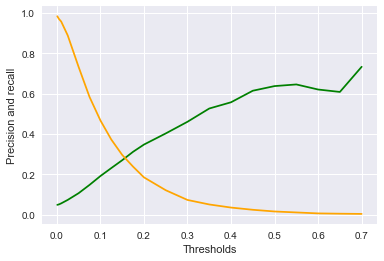

In [21]:
def printRecallPrecision():
    alpha = 0.001
    thresholds = [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
    precisions = []
    recalls = []
    for threshold in thresholds:
        model = linear_model.Lasso(alpha=alpha)
        precision, recall, score, roc = evalLasso(model, X_train, y_train, X_test, y_test, threshold)
        precisions.append(precision)
        recalls.append(recall)
        
    plt.plot(thresholds, precisions, color='green')
    plt.plot(thresholds, recalls, color='orange')
    plt.xlabel('Thresholds')
    plt.ylabel('Precision and recall')
    plt.show();
printRecallPrecision()

Vemos como, si tomamos como clases con Bugs aquellas con una probabilidad mayor que 0.1, en función del valor de la regularización escogida, iremos bajando el recall pero aumentando la precisión a medida que lo aumentemos. Aquí habría que valorar si es conveniente asegurar una buen precisión, para que siempre que avisemos sea por un fallo muy posible; o tenemos en cuenta los dos criterios.

In [37]:
model = linear_model.Lasso(alpha=0.01)
evalLasso(model, X_train, y_train, X_test, y_test, 0.05)

(0.11285395370696745,
 0.7034053460270963,
 0.19450210094669165,
 0.7205059952842299)

In [23]:
model = linear_model.Lasso(alpha=0.01)
evalLasso(model, X_train, y_train, X_test, y_test, 0.025)

(0.07086773280988395,
 0.8989381179055291,
 0.13137826773339042,
 0.6698301300027898)

In [24]:
model = linear_model.Lasso(alpha=0.1)
evalLasso(model, X_train, y_train, X_test, y_test, 0.4)

(0.47368421052631576,
 0.013181984621017943,
 0.025650160313501962,
 0.5062434744567793)

In [22]:
X_transformed, y_transformed = undersampling(train_df, frac_negatives=0.5)
model = linear_model.Lasso(alpha=0.01)
evalLasso(model, X_transformed, y_transformed, X_test, y_test, 0.1)

(0.11897889808222692,
 0.6792383742218967,
 0.20248881126514573,
 0.7202815561401573)

In [26]:
X_transformed, y_transformed = oversampling(train_df, frac_positives=1.5)
model = linear_model.Lasso(alpha=0.01)
evalLasso(model, X_transformed, y_transformed, X_test, y_test, 0.1)

(0.15024232633279483,
 0.5789088246063713,
 0.23856948845631507,
 0.7117667961019033)

In [36]:
X_transformed, y_transformed = overundersampling(train_df, frac_positives = 1.5, frac_negatives=0.5)
model = linear_model.Lasso(alpha=0.01)
evalLasso(model, X_transformed, y_transformed, X_test, y_test, 0.15)

(0.12694593829606568,
 0.6569022336140607,
 0.212773527842021,
 0.7212592348240934)

### 5) SVM

In [78]:
# Tarda mucho en ejecutarse
# model = svm.SVC()
# tryModel(model, X_train, y_train, X_test, y_test)
# Resultados: (0.43333333333333335, 0.04760161113145368, 0.08578027053777632, 0.5223238546873754)

(0.43333333333333335,
 0.04760161113145368,
 0.08578027053777632,
 0.5223238546873754)

Se puede ver que no clasifica casi datos como positivos.

In [14]:
# model = svm.SVC()
# tryModel(model, X_undersampling, y_undersampling, X_test, y_test)
# Reultados: (0.37449392712550605, 0.06774075430245331, 0.11472868217054263, 0.5311858017311645)

(0.37449392712550605,
 0.06774075430245331,
 0.11472868217054263,
 0.5311858017311645)

In [15]:
# model = svm.SVC()
# tryModel(model, X_oversampling, y_oversampling, X_test, y_test)
# Resultados: (0.3569553805774278, 0.09959721713658001, 0.15574005153163473, 0.5455415148601007)

(0.3569553805774278,
 0.09959721713658001,
 0.15574005153163473,
 0.5455415148601007)

In [16]:
# model = svm.SVC()
# tryModel(model, X_overundersampling, y_overundersampling, X_test, y_test)
# Resultados: (0.29074074074074074, 0.11497619919443428, 0.16478614536866967, 0.5508331326982927)

(0.29074074074074074,
 0.11497619919443428,
 0.16478614536866967,
 0.5508331326982927)

### 6) XGBoost

In [29]:
from xgboost import XGBClassifier
model = XGBClassifier()
tryModel(model, X_train, y_train, X_test, y_test)

C:\Users\Diego\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(0.6666666666666666,
 0.016843647015745148,
 0.032857142857142856,
 0.508222000741978)

### 7) Reconsiderar conjunto de entrenamiento

En lugar de aglutinar todas las clases de todas las releases de todos los proyectos simultáneamente, cogeremos los datos de un solo proyecto para ver si los resultados son los mismos.

In [9]:
# Preprocesamiento del Notebook "Estudio de los datos"
def preProcessClasses(classes_df):
    classes_df = classes_df.drop(["CLC", "CLLC", "LLDC"], 1)
    classes_df = classes_df.drop(["CLOC", "TCD"], 1)
    classes_df = classes_df.drop(["TLLOC", "TLOC"], 1)
    classes_df = classes_df.drop("TNLPM", 1)
    classes_df = classes_df.drop("TNLS", 1)
    classes_df = classes_df.drop("TNOS", 1)
    classes_df = classes_df.drop("TNPM", 1)
    classes_df = classes_df.drop(["LLOC", "NLPM", "NPM"], 1)
    classes_df = classes_df.drop("WarningBlocker", 1)
    classes_df = classes_df.drop("Android Rules", 1)
    classes_df = classes_df.drop("Clone Implementation Rules", 1)
    classes_df = classes_df.drop("Code Size Rules", 1)
    classes_df = classes_df.drop("Comment Rules", 1)
    classes_df = classes_df.drop("Coupling Rules", 1)
    classes_df = classes_df.drop("Empty Code Rules", 1)
    classes_df = classes_df.drop("Finalizer Rules", 1)
    classes_df = classes_df.drop("Import Statement Rules", 1)
    classes_df = classes_df.drop("J2EE Rules", 1)
    classes_df = classes_df.drop("Jakarta Commons Logging Rules", 1)
    classes_df = classes_df.drop("Java Logging Rules", 1)
    classes_df = classes_df.drop("JavaBean Rules", 1)
    classes_df = classes_df.drop("MigratingToJUnit4 Rules", 1)
    classes_df = classes_df.drop("Migration Rules", 1)
    classes_df = classes_df.drop("Migration13 Rules", 1)
    classes_df = classes_df.drop("Migration14 Rules", 1)
    classes_df = classes_df.drop("Migration15 Rules", 1)
    classes_df = classes_df.drop("Security Code Guideline Rules", 1)
    classes_df = classes_df.drop("Unnecessary and Unused Code Rules", 1)
    classes_df = classes_df.drop("Vulnerability Rules", 1)
    return classes_df

In [10]:
def saveProjectData(projectName, outputFile):
    # Dataframes with class attributes
    classes = None

    # Set the path of the input folder 
    data = "datasets/GitHubBugDataSet/database"
    data_output = "datasets/dataframes/"+outputFile

    # List out the projects inside input folder
    projects = os.listdir(data)

    # Look for Class files of each directory
    for project in projects:
    
        if (project == projectName):
            # Look for each release
            releases = os.listdir(data + "/" + project)
            for release in releases:
                # Look for Class csv
                dataset = os.listdir(data + "/" + project + "/" + release)
                for file in dataset:
                    # ....Class.csv file
                    if(file.endswith("Class.csv")) :
                        classdf = pd.read_csv(data + "/" + project + "/" + release + '/' + file)
                        if (classes is None):
                            classes = classdf.copy()
                        else:
                            classes = classes.append(classdf)
                        break
            break

    
    try:
        # Delete duplicate rows
        classes = classes.drop_duplicates()

        # Delete non-numeric columns
        classes = classes.drop(["ID", "Name", "LongName", "Parent", "Component", "Path"], axis=1)
        
        # Preprocess dataframe
        classes = preProcessClasses(classes)
        
        # Write whole processed dataset into 1 file
        classes.to_csv(data_output + '.csv', index = False)
    
        return classes
    except:
        return None

In [5]:
# Guardar cada proyecto de manera independiente
projects = ["Android-Universal-Image-Loader","antlr4","BroadleafCommerce","ceylon-ide-eclipse","elasticsearch","hazelcast","junit","MapDB","mcMMO","mct","neo4j","netty","orientdb","oryx","titan"]
for project in projects:
    # Descomentar solo si se han borrado los archivos csv de la ruta datasets/dataframes, 
    # saveProjectData(project, project)
    pass

Tras guardar los datos de los proyectos de manera individual, vamos a probar a dividirlos en conjunto de entrenamiento y de test, balancear el de entrenamiento y observar los resultados en el de test.

In [12]:
def analyzeProject(project):
    classes_df = pd.read_csv(input_data + project + ".csv")
    
    # Binarizar variable clase
    old_label = "Number of bugs"
    label = "Has bugs"
    classes_df[label] = classes_df[old_label] > 0
    classes_df = classes_df.drop(old_label, axis = 1)
    
    # Atts and label(binary -> False: no bugs, True: bugs)
    classes_df_atts = classes_df.drop([label], axis = 1)
    classes_df_label = classes_df[label]

    #print("Clases sin bugs (negativos): ",len(classes_df_label[~classes_df_label]))
    #print("Clases con bugs (positivos): ", len(classes_df_label[classes_df_label]))
    #print("Proporcion de clases con bugs: ", round(len(classes_df_label[classes_df_label])/len(classes_df_label)*100,2),'%')

    # Train / Test split
    X_train, X_test, y_train, y_test = train_test_split(classes_df_atts, classes_df_label, test_size=0.33, stratify=classes_df_label)


    # Train and test df
    train_df = X_train.copy()
    train_df[label] = y_train.copy()
    test_df = X_test.copy()
    test_df[label] = y_test.copy()
    
    # Balancear train set
    # Contar casos positivos
    train_df_positive = train_df[train_df[label]]
    n_cases = len(train_df_positive)
    # Negative cases -> Delete some cases
    train_df_negative = train_df[~train_df[label]]
    train_df_negative = train_df_negative.sample(n = n_cases)
    # Join negative and positives cases
    train_df = train_df_positive.append(train_df_negative).sample(frac=1)
    # Separate in attributes and label
    X_train = train_df.drop(label, 1)
    y_train = train_df[label]

    #print("Clases con bugs en train set (positivos): ", len(train_df[train_df[label]]))
    #print("Clases sin bugs en train set (negativos): ",len(train_df[~train_df[label]]))

    # Crear un árbol de decisión y comprobar rendimiento
    model = tree.DecisionTreeClassifier()
    return tryModel(model, X_train, y_train, X_test, y_test)

Mostraremos en una gráfica la precisión, el recall y el área bajo la curva de cada proyecto.

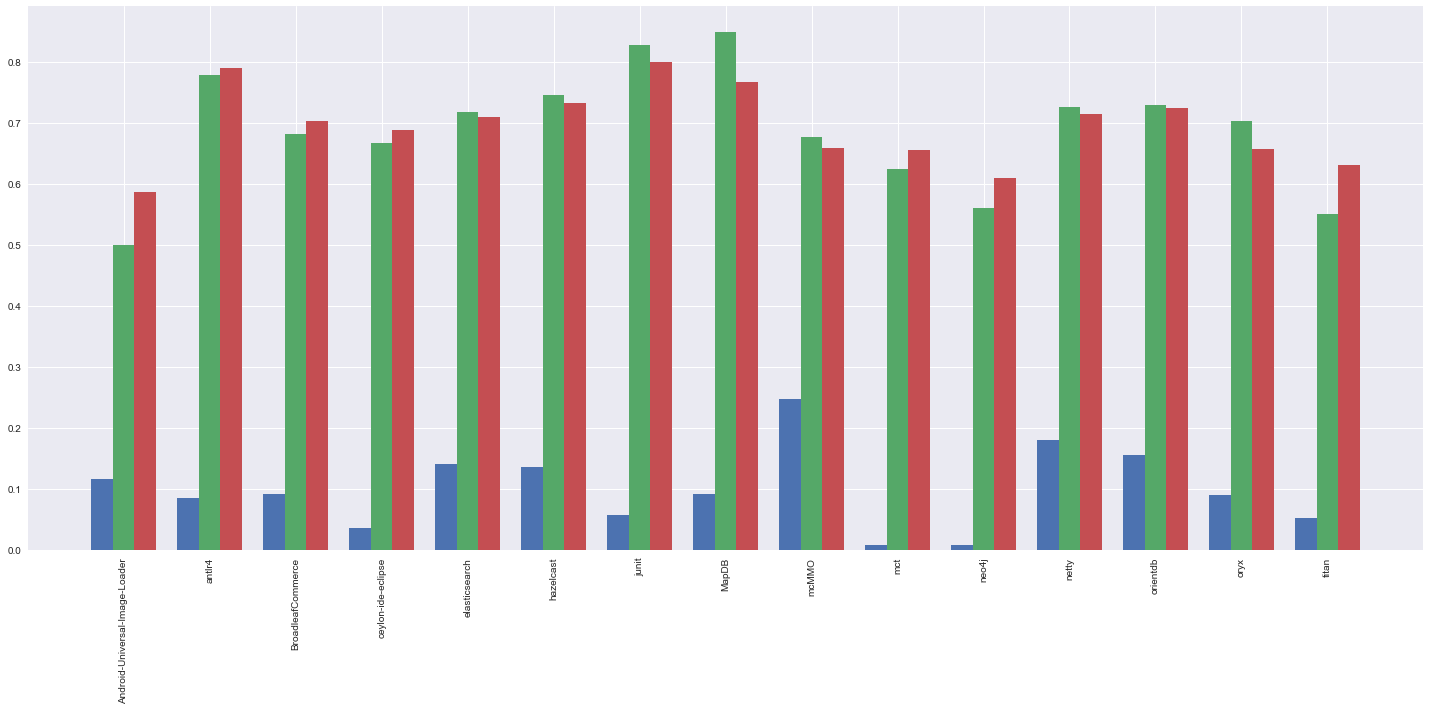

In [14]:
precisions = []
recalls = []
aucs = []
for project in projects:
    prec, recall, f1, auc = analyzeProject(project)
    precisions.append(prec)
    recalls.append(recall)
    aucs.append(auc)
    #print("Proyecto ", project)
    #print("Accuracy: ", acc)
    #print("Precision: ", prec)
    #print("Recall: ", recall)
    #print("AUC: ", auc)
    #print("----------------------")
X = np.arange(len(projects))
plt.figure(figsize=(25,10))
plt.bar(X-0.25, precisions, width=0.25)
plt.bar(X, recalls, width=0.25)
plt.bar(X+0.25, aucs, width=0.25)
locs, labels = plt.xticks(X, projects, rotation = 90)
plt.show();
    

Se puede ver como la precisión en general es baja, sobre un 15-20%, y el recall suele ser más alto, sobre un 70%

Por último, vamos a intentar entrenar con datos de un proyecto y predecir sobre otro para ver el resultado.

In [15]:
def trainProjectForAnother(projectTrain, projectTest):
    # Primer conjunto de datos -> Entrenamos modelo con él
    classes_df = pd.read_csv(input_data + projectTrain + ".csv")
    
    # Binarizar variable clase
    old_label = "Number of bugs"
    label = "Has bugs"
    classes_df[label] = classes_df[old_label] > 0
    classes_df = classes_df.drop(old_label, axis = 1)
    
    # Atts and label(binary -> False: no bugs, True: bugs)
    classes_df_atts = classes_df.drop([label], axis = 1)
    classes_df_label = classes_df[label]

    # Balancear set
    # Contar casos positivos
    train_df_positive = classes_df[classes_df[label]]
    n_cases = len(train_df_positive)
    # Negative cases -> Delete some cases
    train_df_negative = classes_df[~classes_df[label]]
    train_df_negative = train_df_negative.sample(n = n_cases)
    # Join negative and positives cases
    train_df = train_df_positive.append(train_df_negative).sample(frac=1)
    
    # Separate in attributes and label
    X_train = train_df.drop(label, 1)
    y_train = train_df[label]
    
    
    # Segundo conjunto de datos -> Predecir con él
    classes_df_2 = pd.read_csv(input_data + projectTest + ".csv")
    
    # Binarizar variable clase
    old_label = "Number of bugs"
    label = "Has bugs"
    classes_df_2[label] = classes_df_2[old_label] > 0
    classes_df_2 = classes_df_2.drop(old_label, axis = 1)
    
    # Atts and label(binary -> False: no bugs, True: bugs)
    classes_df_atts = classes_df_2.drop([label], axis = 1)
    classes_df_label = classes_df_2[label]

    # Crear un árbol de decisión y comprobar rendimiento
    model = tree.DecisionTreeClassifier()
    return tryModel(model, X_train, y_train, classes_df_atts, classes_df_label)

In [16]:
trainProjectForAnother("antlr4", "BroadleafCommerce")

(0.057604641525072525,
 0.20262390670553937,
 0.08970635688931913,
 0.5333583315502356)

In [17]:
trainProjectForAnother("elasticsearch", "hazelcast")

(0.09490436560081764,
 0.4659498207885305,
 0.15769044153323628,
 0.6023431406804372)

In [18]:
trainProjectForAnother("hazelcast", "elasticsearch")

(0.09829250185597624,
 0.5716753022452504,
 0.1677435702521221,
 0.6071674540058263)

En este caso, los resultados no son tan buenos como en el caso anterior.

### 8) Tratar solo los casos del build con mas registros positivos

En este punto vamos a intentar coger de cada proyecto únicamente el build con más casos positivos, para ver si las diferencias son significativas.

In [29]:
def saveProjectDataForBiggestBuild(projectName, outputFile):
    # Dataframes with class attributes
    classes = None
    # Max number of positive cases found
    max_positives = 0
    
    # Set the path of the input folder 
    data = "datasets/GitHubBugDataSet/database"
    data_output = "datasets/dataframes/"+outputFile

    # List out the projects inside input folder
    projects = os.listdir(data)

    # Look for Class files of each directory
    for project in projects:
    
        if (project == projectName):
            # Look for each release
            releases = os.listdir(data + "/" + project)
            for release in releases:
                # Look for Class csv
                dataset = os.listdir(data + "/" + project + "/" + release)
                for file in dataset:
                    # ....Class.csv file
                    if(file.endswith("Class.csv")) :
                        classdf = pd.read_csv(data + "/" + project + "/" + release + '/' + file)
                        n = len(classdf[classdf["Number of bugs"] > 0])
                        if (n > max_positives):
                            classes = classdf.copy()
                            max_positives = n
                        break
            break

    
    try:
        # Delete duplicate rows
        classes = classes.drop_duplicates()

        # Delete non-numeric columns
        classes = classes.drop(["ID", "Name", "LongName", "Parent", "Component", "Path"], axis=1)
        
        # Preprocess dataframe
        classes = preProcessClasses(classes)
        
        # Write whole processed dataset into 1 file
        classes.to_csv(data_output + '.csv', index = False)
    
        return classes
    except:
        return None

In [30]:
for project in projects:
    saveProjectDataForBiggestBuild(project,project+"-bigBuild")

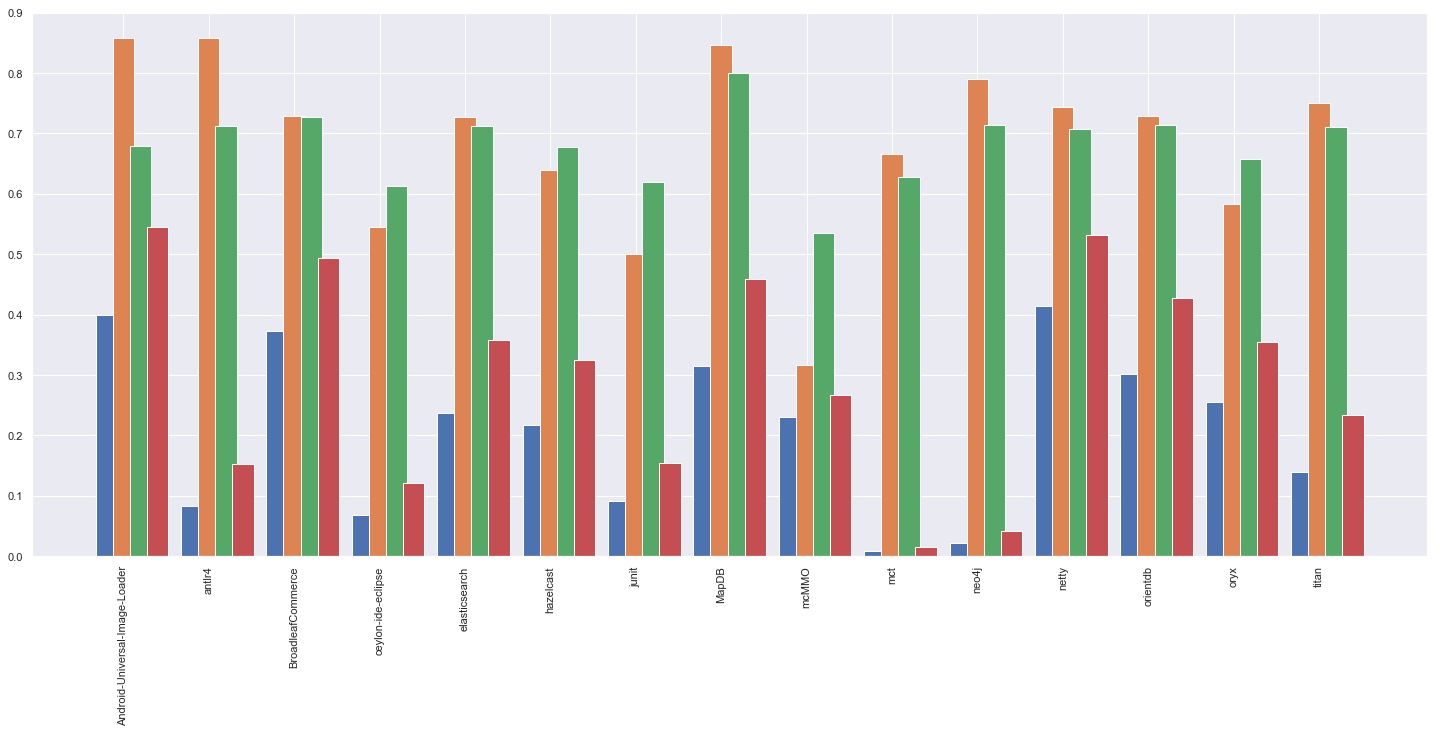

In [13]:
precisions = []
recalls = []
aucs = []
for project in projects:
    prec, recall, f1, auc = analyzeProject(project+"-bigBuild")
    precisions.append(prec)
    recalls.append(recall)
    aucs.append(auc)
    #print("Proyecto ", project)
    #print("Accuracy: ", acc)
    #print("Precision: ", prec)
    #print("Recall: ", recall)
    #print("AUC: ", auc)
    #print("----------------------")
X = np.arange(len(projects))
plt.figure(figsize=(25,10))
plt.bar(X-0.25, precisions, width=0.25)
plt.bar(X, recalls, width=0.25)
plt.bar(X+0.25, aucs, width=0.25)
locs, labels = plt.xticks(X, projects, rotation = 90)
plt.show();

Se puede ver como la precisión ha subido algo, y el recall es parecido al caso anterior. También es conveniente recalcar que así el número de casos ha sido muy pequeño (hay proyectos en los que solo hay 20-30 casos positivos en un build).